In [1]:
import os
if os.name=='nt':
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time

%matplotlib inline

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.name

'nt'

In [2]:
n_train = 1183747
n_test = 1183748

In [3]:
# I'm limited by RAM here and taking the first N rows is likely to be
# a bad idea for the date data since it is ordered.
# Sample the data in a roundabout way:


def load_chunk(chunk_size=100, n_chunk=2, frac_chunk=0.05):
    
    date_chunks = pd.read_csv("data/train_date.csv.zip", index_col=0, chunksize=chunk_size, dtype=np.float32)
    num_chunks = pd.read_csv("data/train_numeric.csv.zip", index_col=0,
                         usecols=list(range(969)), chunksize=chunk_size, dtype=np.float32)
    cat_chunks = pd.read_csv('data/train_categorical.csv.zip', index_col=0, chunksize=chunk_size)
    
    n = 0
    tmp = []
    #for dchunk, nchunk, cchunk in zip(date_chunks, num_chunks, cat_chunks):
        #tmp.append(pd.concat([dchunk, nchunk, cchunk], axis=1).sample(frac=frac_chunk))
    start_time = time.time()
    for dchunk, nchunk in zip(date_chunks, num_chunks):
        tmp.append(pd.concat([dchunk, nchunk], axis=1).sample(frac=frac_chunk))
        n += 1
        memory_usage = sum([x.memory_usage(deep=True).sum()*10**-9 for x in tmp])
        running_time = time.time() - start_time
        print('Chunk {} loaded. Total size of data: {:.3f} GB. Running time: {:.3f} sec.'.format(
              n, memory_usage, running_time))
        if n>=n_chunk:
            break
    
    X = pd.concat(tmp)
    y = pd.read_csv("data/train_numeric.csv.zip", index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()
    X = X.values
    
    return X, y

In [4]:
X, y = load_chunk(chunk_size=100000, n_chunk=12, frac_chunk=1.0)

Chunk 1 loaded. Total size of data: 0.850 GB. Running time: 10.717 sec.
Chunk 2 loaded. Total size of data: 1.701 GB. Running time: 21.329 sec.
Chunk 3 loaded. Total size of data: 2.551 GB. Running time: 31.742 sec.
Chunk 4 loaded. Total size of data: 3.402 GB. Running time: 42.213 sec.
Chunk 5 loaded. Total size of data: 4.252 GB. Running time: 52.665 sec.
Chunk 6 loaded. Total size of data: 5.102 GB. Running time: 63.113 sec.
Chunk 7 loaded. Total size of data: 5.953 GB. Running time: 73.656 sec.
Chunk 8 loaded. Total size of data: 6.803 GB. Running time: 84.188 sec.
Chunk 9 loaded. Total size of data: 7.654 GB. Running time: 94.774 sec.
Chunk 10 loaded. Total size of data: 8.504 GB. Running time: 105.261 sec.
Chunk 11 loaded. Total size of data: 9.354 GB. Running time: 115.825 sec.
Chunk 12 loaded. Total size of data: 10.067 GB. Running time: 124.652 sec.


/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
clf = XGBClassifier(base_score=0.005, n_estimators=200, max_depth=9, n_jobs=6)
clf.fit(X, y, verbose=True)

XGBClassifier(base_score=0.005, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

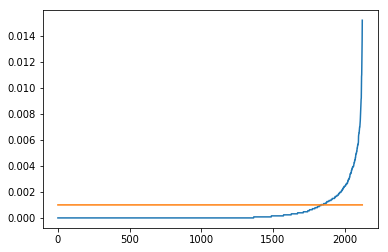

In [6]:
important_indices = np.where(clf.feature_importances_>0.001)[0]
plt.plot(sorted(clf.feature_importances_))
plt.plot(0.001*np.ones(len(clf.feature_importances_)))

(array([120.,  43.,  39.,  17.,  21.,  12.,  10.,   5.,   7.,   2.,   3.,
          3.,   0.,   2.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([0.00102386, 0.00173269, 0.00244152, 0.00315035, 0.00385918,
        0.00456801, 0.00527684, 0.00598567, 0.00669449, 0.00740332,
        0.00811215, 0.00882098, 0.00952981, 0.01023864, 0.01094747,
        0.0116563 , 0.01236513, 0.01307395, 0.01378278, 0.01449161,
        0.01520044]),
 <a list of 20 Patch objects>)

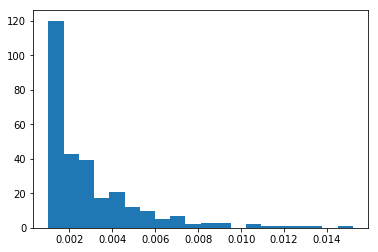

In [7]:
plt.hist(clf.feature_importances_[important_indices], 20)

In [8]:
important_indices

array([   0,   12,   14,   23,   32,   34,   36,   41,   50,   63,   76,
         89,  103,  112,  121,  123,  125,  130,  393,  805,  831,  883,
        939,  946,  960, 1018, 1019, 1029, 1034, 1042, 1050, 1056, 1156,
       1157, 1158, 1159, 1160, 1161, 1163, 1164, 1165, 1166, 1167, 1168,
       1169, 1171, 1173, 1174, 1177, 1178, 1180, 1182, 1183, 1186, 1187,
       1188, 1189, 1190, 1191, 1193, 1194, 1196, 1197, 1201, 1202, 1203,
       1204, 1206, 1207, 1208, 1209, 1210, 1213, 1214, 1215, 1216, 1218,
       1219, 1220, 1221, 1222, 1225, 1226, 1227, 1228, 1230, 1232, 1233,
       1234, 1235, 1236, 1237, 1238, 1239, 1245, 1246, 1247, 1249, 1250,
       1252, 1254, 1258, 1259, 1261, 1263, 1267, 1269, 1270, 1271, 1272,
       1274, 1275, 1277, 1278, 1283, 1285, 1297, 1298, 1299, 1301, 1304,
       1307, 1311, 1313, 1318, 1323, 1356, 1404, 1412, 1476, 1477, 1480,
       1481, 1482, 1483, 1484, 1486, 1487, 1488, 1490, 1492, 1493, 1494,
       1502, 1505, 1507, 1510, 1513, 1516, 1517, 15

In [ ]:
clf = XGBClassifier(max_depth=9, n_estimators=200, base_score=0.006, n_jobs=6)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.711


/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.21465928636118392


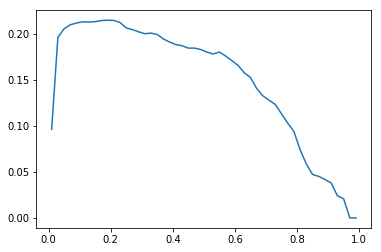

In [10]:
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())